<a href="https://colab.research.google.com/github/ipeirotis/dealing_with_data/blob/master/06-Spatial_Data_and_Maps/Showing_Census_Variables_on_a_Map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install -y -qq libproj-dev proj-data proj-bin libgdal-dev libspatialindex-dev  libgeos-dev

!pip uninstall -y  shapely
!pip install shapely --no-binary shapely

!pip install pyshp six cartopy geopandas fiona pyproj descartes pysal rtree pykdtree pyepsg pillow OWSLib geoplot folium

!pip3 install -U CensusData 

Found existing installation: Shapely 1.8.0
Uninstalling Shapely-1.8.0:
  Successfully uninstalled Shapely-1.8.0
  Using cached Shapely-1.8.0.tar.gz (278 kB)
Skipping wheel build for shapely, due to binaries being disabled for it.
    Running setup.py install for shapely ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
import censusdata
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.6.2-CAPI-1.10.2 4d2925d6) is incompatible with the GEOS version PyGEOS was compiled with (3.10.0-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Setup

In [4]:
STATEFP = "36"  # New York State
COUNTYFP = "061"  # Manhattan
YEAR = 2019

## Download Tract Shapefile for State and Limit Tracts to County of Interest

In [5]:
# Download the census tracts shapes from US Census
# We download from the TIGER shapefiles repository


# Download the boundaries of tracts
filename = f"tl_{YEAR}_{STATEFP}_tract.zip"
!mkdir -p maps
!curl -s https://www2.census.gov/geo/tiger/TIGER$YEAR/TRACT/$filename -o maps/$filename
!cd maps && unzip -o $filename
shapefile = f"maps/{filename[:-4]}.shp"
geo_df = gpd.GeoDataFrame.from_file(shapefile)
# Keep only the data for the county of interest
geo_df = geo_df.query(f"COUNTYFP == '{COUNTYFP}'")

# We download the water areas, to avoid including water areas in our maps
water_filename = f"tl_{YEAR}_{STATEFP+COUNTYFP}_areawater.zip"
!curl -s https://www2.census.gov/geo/tiger/TIGER$YEAR/AREAWATER/$water_filename  -o maps/$water_filename
!cd maps && unzip -o $water_filename
water_shapefile = f"maps/{water_filename[:-4]}.shp"
water_geodf = gpd.GeoDataFrame.from_file(water_shapefile)

# Remove water areas from the tracts
geo_df = gpd.overlay(geo_df, water_geodf, how="difference")


Archive:  tl_2019_36_tract.zip
 extracting: tl_2019_36_tract.cpg    
  inflating: tl_2019_36_tract.dbf    
  inflating: tl_2019_36_tract.prj    
  inflating: tl_2019_36_tract.shp    
  inflating: tl_2019_36_tract.shp.ea.iso.xml  
  inflating: tl_2019_36_tract.shp.iso.xml  
  inflating: tl_2019_36_tract.shx    
Archive:  tl_2019_36061_areawater.zip
 extracting: tl_2019_36061_areawater.cpg  
  inflating: tl_2019_36061_areawater.dbf  
  inflating: tl_2019_36061_areawater.prj  
  inflating: tl_2019_36061_areawater.shp  
  inflating: tl_2019_36061_areawater.shp.ea.iso.xml  
  inflating: tl_2019_36061_areawater.shp.iso.xml  
  inflating: tl_2019_36061_areawater.shx  


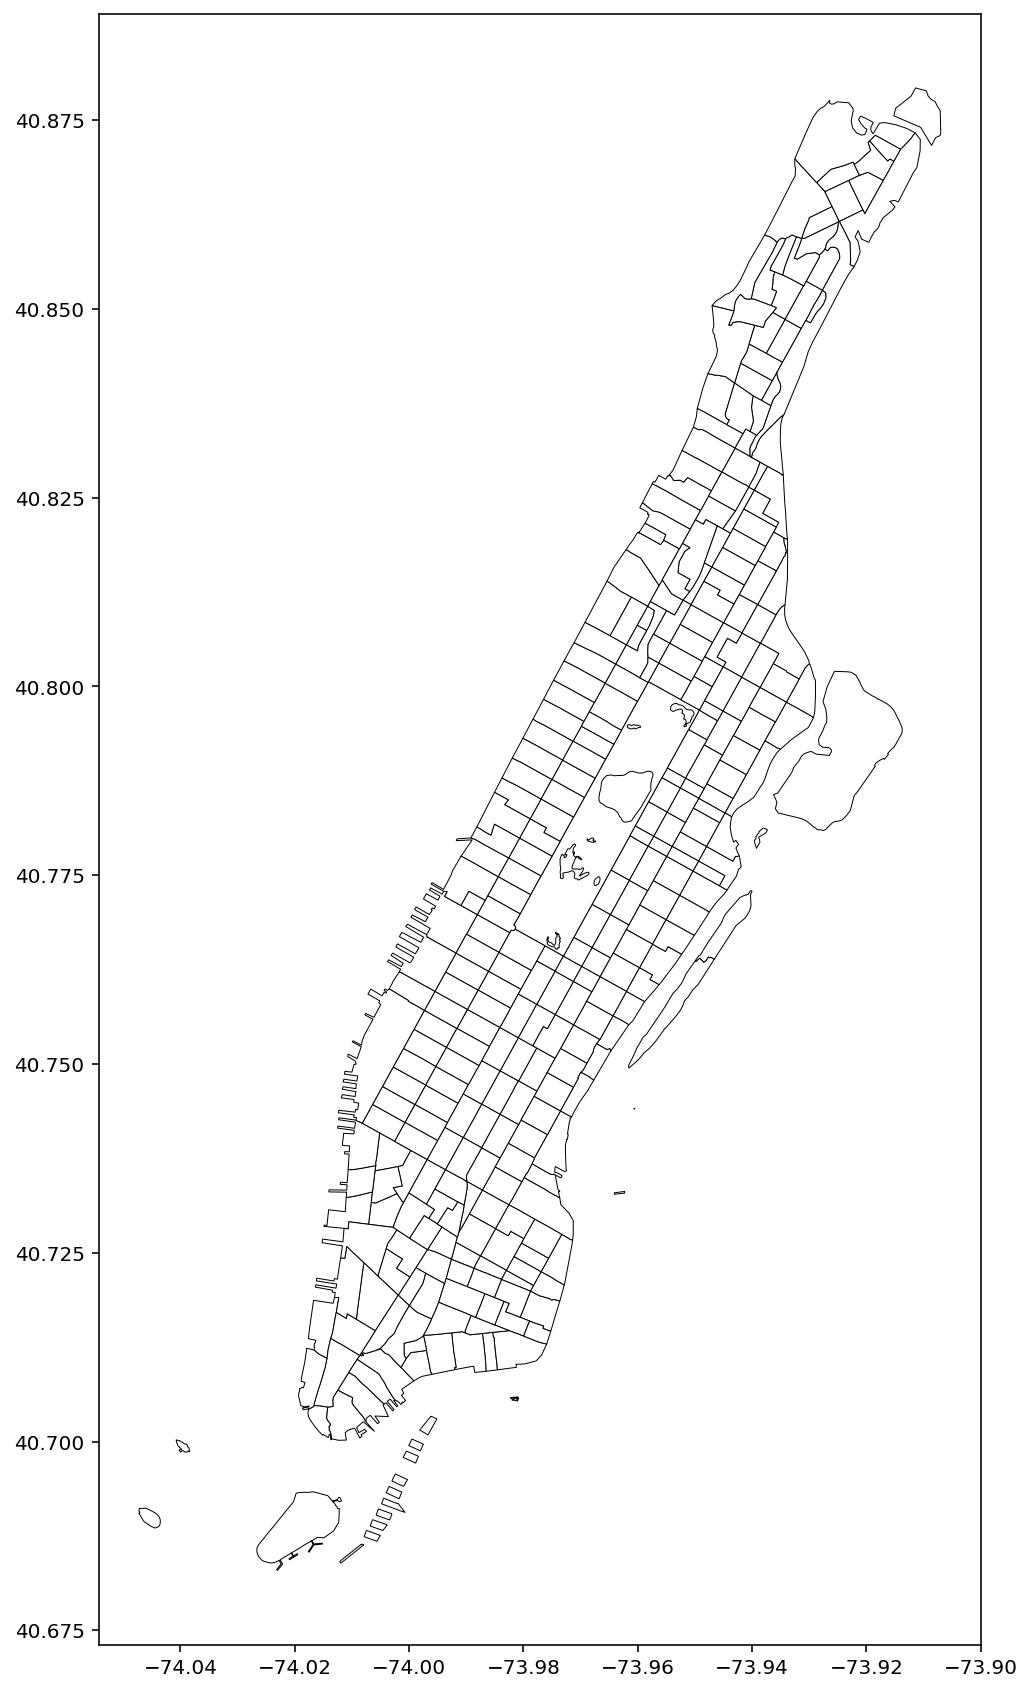

In [6]:
# Plot the tract boundaries
geo_df.plot(
    figsize=(15, 15),
    color="white",
    edgecolor="black",
    linewidth=0.5,
    zorder=0,
    facecolor="white",
)

## Access Census Details for All Tracts in County

In [7]:
some_useful_census_variables = {
        "B07001_001E": "Total_Population",
        "B07013_002E": "Owner",
        "B07013_003E": "Renter",
        "B07001_017E": "Same_house_1_year_ago",
        "B07013_005E": "Same_house_1_year_ago_owner",
        "B07013_006E": "Same_house_1_year_ago_renter",
        "B19127_001E": "Aggregate_Income",             
        "B19126_001E": "Median_Family_Income", 
        "B25064_001E": "Median_Gross_Rent",
        "B25103_001E": "Median_Real_Estate_Taxes",
        "B19083_001E": "Gini_Index",
      
        "B19080_001E": "Household_Income_Lowest_Quintile_Upper_Limit",
        "B19080_002E": "Household_Income_Second_Quintile_Upper_Limit",
        "B19080_003E": "Household_Income_Third_Quintile_Upper_Limit",
        "B19080_004E": "Household_Income_Fourth_Quintile_Upper_Limit",
        "B19080_005E": "Household_Income_Top_5_Percent_Lower_Limit",
        
        "B13016_002E": "Women_Gave_Birth_Last_Year",
        "B13016_010E": "Women_No_Birth_Last_Year",

        "B25038_015E": "Renter_Moved_in_1979_or_earlier",
        "B25038_014E": "Renter_Moved_in_1980_to_1989",
        "B25038_013E": "Renter_Moved_in_1990_to_1999",
        "B25038_012E": "Renter_Moved_in_2000_to_2009",
        "B25038_011E": "Renter_Moved_in_2010_to_2014",
        "B25038_010E": "Renter_Moved_in_2015_or_later",
        
        "B25038_008E": "Owner_Moved_in_1979_or_earlier",
        "B25038_007E": "Owner_Moved_in_1980_to_1989",
        "B25038_006E": "Owner_Moved_in_1990_to_1999",
        "B25038_005E": "Owner_Moved_in_2000_to_2009",
        "B25038_004E": "Owner_Moved_in_2010_to_2014",
        "B25038_003E": "Owner_Moved_in_2015_or_later",
        
        "B11016_002E": "Family_households",
        "B11016_003E": "Family_households_2person",
        "B11016_004E": "Family_households_3person",
        "B11016_005E": "Family_households_4person",
        "B11016_006E": "Family_households_5person",
        "B11016_007E": "Family_households_6person",
        "B11016_008E": "Family_households_7_or_more",
        
        "B11016_009E": "NonFamily_households",
        "B11016_010E": "NonFamily_households_1person",
        "B11016_011E": "NonFamily_households_2person",
        "B11016_012E": "NonFamily_households_3person",
        "B11016_013E": "NonFamily_households_4person",
        "B11016_014E": "NonFamily_households_5person",
        "B11016_015E": "NonFamily_households_6person",
        "B11016_016E": "NonFamily_households_7_or_more",
     
        "B01001_001E": "Total_Population_All_Races",
        "B01001A_001E": "Total_Population_White",
        "B01001B_001E": "Total_Population_Black",     
        "B01001C_001E": "Total_Population_Native",
        "B01001D_001E": "Total_Population_Asian",     
        "B01001E_001E": "Total_Population_PacificIslander",
        "B01001F_001E": "Total_Population_Other",     
        "B01001G_001E": "Total_Population_Multiple",
        "B01001H_001E": "Total_Population_White_NonHispanic",
        "B01001I_001E": "Total_Population_Hispanic"
 }


In [8]:
def retrieve_census_data(census_attr, friendly_name):

  # We specify what locations we want the data for
  # We will retrieve information for all the tracts in 
  # the state (STATEFP) and county (COUNTYFP) that we
  # specified earlier
  census_location_query = [("state", STATEFP), ("county", COUNTYFP), ("tract", "*")]
  census_attribute_query = [census_attr]

  # Download data for the variable of interest from census
  df = censusdata.download(
      "acs5", # we use the ACS survey, 5-year data
      YEAR, # we use the data from the 2019 survey
      censusdata.censusgeo(census_location_query),
      census_attribute_query,
  )
  df = df.rename({census_attr: friendly_name}, axis="columns")

  # To visualize the variable, we will assign a percentile score to
  # each tract (otherwise outlier values make it hard to differentiate) 
  df[friendly_name + "_percentile"] = df[friendly_name].rank(pct=True)

  # Replace the index of the dataframe with state, county, and tract values
  df = df.reset_index().rename({"index": "tract_info"}, axis="columns")
  df["state"] = [v.geo[0][1] for v in df.tract_info.values]
  df["county"] = [v.geo[1][1] for v in df.tract_info.values]
  df["tract"] = [v.geo[2][1] for v in df.tract_info.values]
  df = df.drop("tract_info", axis="columns")

  # replace missing value indicator with NaN
  df = df.replace(to_replace=-666666666, value=pd.NA) 

  return df

In [23]:
  # We specify the attribute(s) that we want to retrieve
  census_attr = "B07001_001E"
  friendly_name = "Total_Population"

  df = retrieve_census_data(census_attr, friendly_name)

  df

,Total_Population,Total_Population_percentile,state,county,tract
0,5982,0.552083,36,061,025500
1,3325,0.253472,36,061,022200
2,1535,0.090278,36,061,001001
3,8470,0.826389,36,061,000700
4,2042,0.125000,36,061,010300
...,...,...,...,...,...
283,6236,0.593750,36,061,021800
284,7915,0.788194,36,061,028300
285,12059,0.972222,36,061,029100
286,8161,0.798611,36,061,029500


## Visualizing Census Variables on a Map

### Population in Tract

In [25]:
aux_df = pd.merge(
    geo_df,
    df,
    left_on=["STATEFP", "COUNTYFP", "TRACTCE"],
    right_on=["state", "county", "tract"],
)

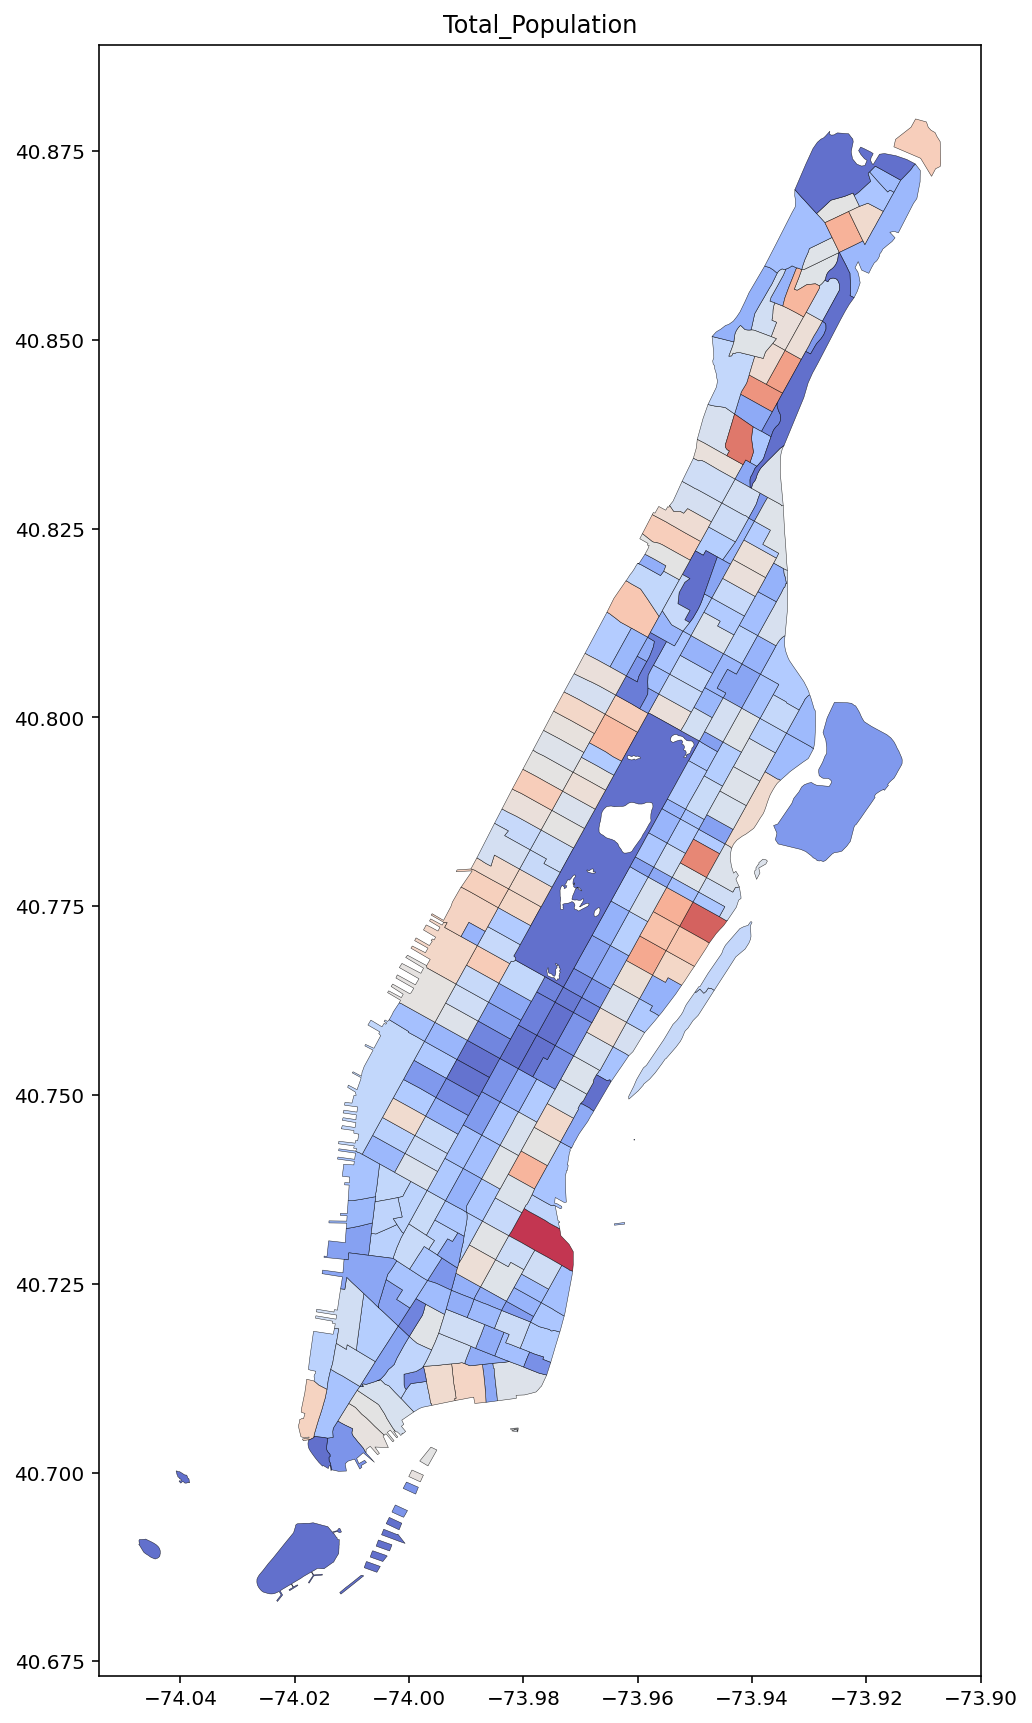

In [27]:
# Plotting the raw population values
# Notice that due to a few outlier values, most
# of the map looks blue
ax = aux_df.plot(
    column=friendly_name,
    linewidth=0.25,
    edgecolor="Black",
    figsize=(15, 15),
    cmap="coolwarm",
    alpha=0.8,
)
ax.set_title(friendly_name)
pass # do not print the title in the output

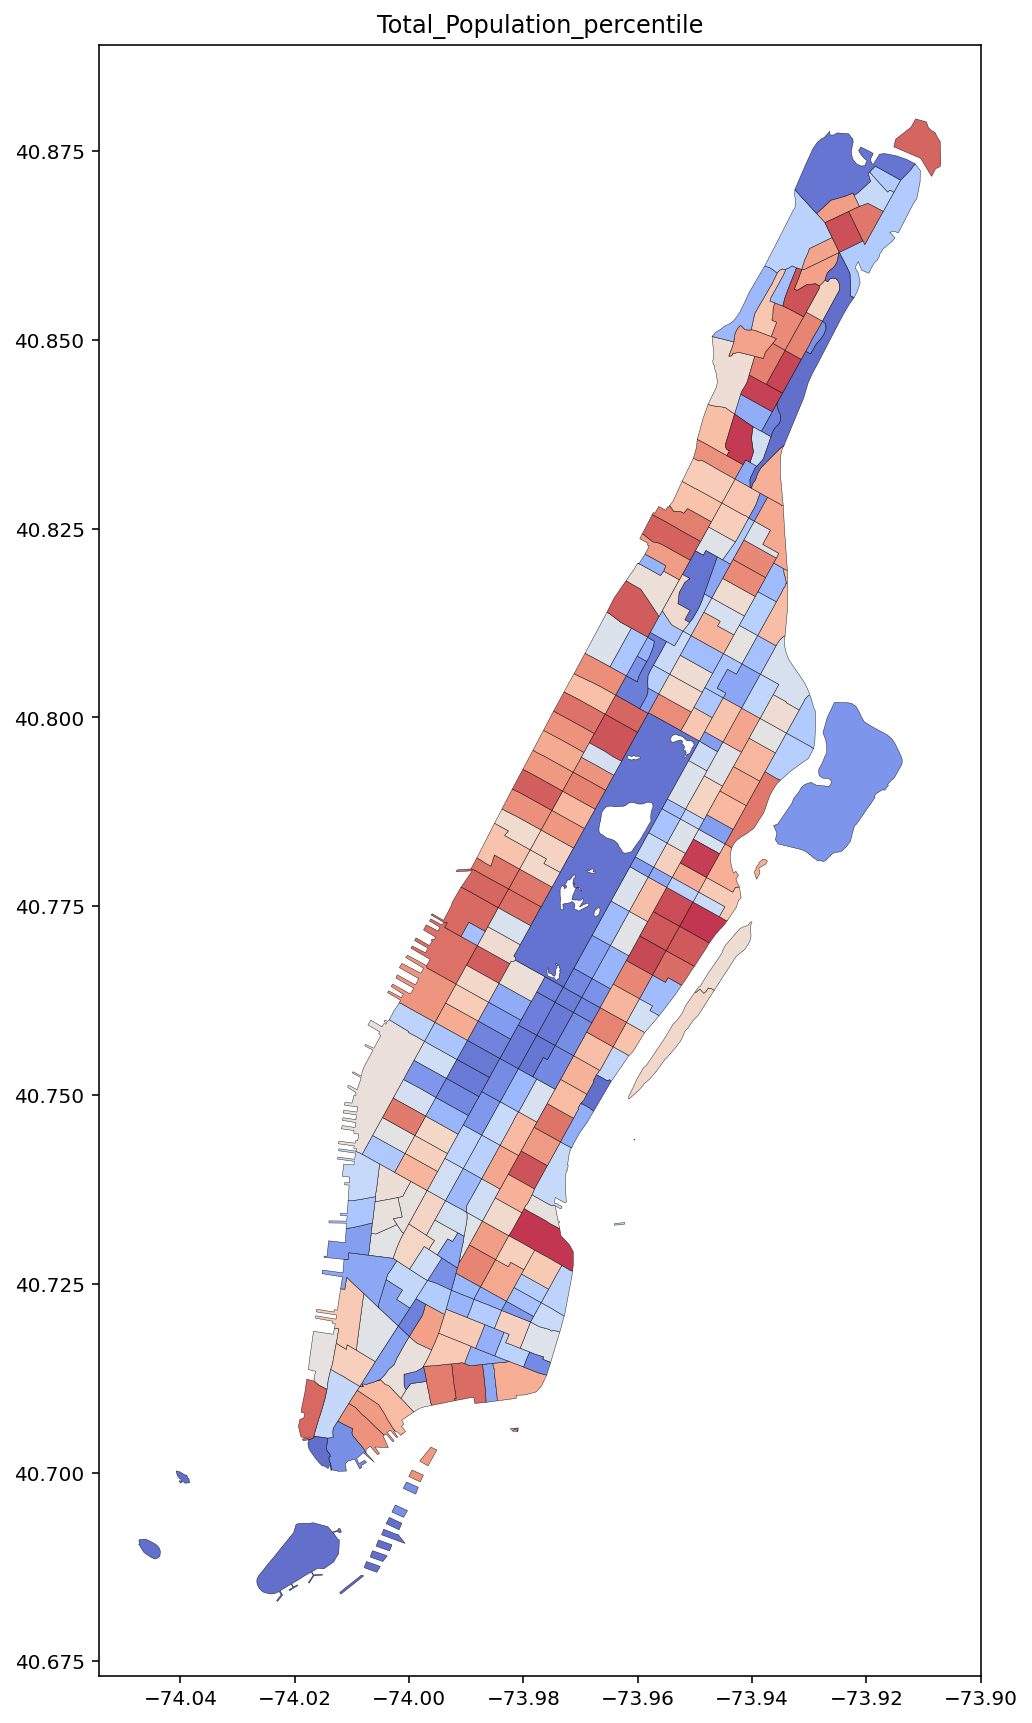

In [28]:
# By using the percentile values instead (which are normalized and uniform)
# the colors associated with each tract are now more informative (at the
# expense of not highlighting the outliers)
ax = aux_df.plot(
    column=friendly_name + "_percentile",
    linewidth=0.25,
    edgecolor="Black",
    figsize=(15, 15),
    cmap="coolwarm",
    alpha=0.8,
)
ax.set_title(friendly_name + "_percentile")
pass # do not print the title in the output

## Putting multiple maps on a plot, plus Manhattan neighborhoods

In [29]:
# Dataset from NYC Open Data: https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas/cpf4-rkhq
nyc_geourl = "https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=GeoJSON"
nyc_neighborhoods = gpd.GeoDataFrame.from_file(nyc_geourl)
manhattan = nyc_neighborhoods[nyc_neighborhoods.county_fips == "061"]

In [30]:
def plot_variable(df, variable_name, percentile, ax):

  if percentile: suffix = "_percentile" 
  else:  suffix = "" 
  
    # Plot the variable of interest
  ax = df.plot(
      column=variable_name + suffix,
      linewidth=0.5,
      edgecolor="Black",
      cmap="coolwarm",
      alpha=0.6,
      ax = ax
  )
  ax.set_title(variable_name + suffix)

  # For aesthetics, we plot the NYC neighborhoods on top
  manhattan.plot(
      color="white",
      edgecolor="black",
      linewidth=2,
      zorder=0,
      facecolor="white",
      ax=ax,
  )
  return ax

In [31]:
census_attr = "B19126_001E"
friendly_name = "Median_Family_Income"
income_df = retrieve_census_data(census_attr, friendly_name)
income_df = pd.merge(geo_df, income_df, left_on=["STATEFP", "COUNTYFP", "TRACTCE"], right_on=["state", "county", "tract"])

In [32]:
census_attr = "B19083_001E"
friendly_name = "Gini_Index"
gini_df = retrieve_census_data(census_attr, friendly_name)
gini_df = pd.merge(geo_df, gini_df, left_on=["STATEFP", "COUNTYFP", "TRACTCE"], right_on=["state", "county", "tract"])

In [33]:
census_attr = "B07001_001E"
friendly_name = "Total_Population"
population_df = retrieve_census_data(census_attr, friendly_name)
population_df = pd.merge(geo_df, population_df, left_on=["STATEFP", "COUNTYFP", "TRACTCE"], right_on=["state", "county", "tract"])

# Using the land area of each tract, we can calculate the population density
# to account for the different sizes of the tracts
population_df['Population_Density'] = population_df['Total_Population']/population_df['ALAND']
population_df['Population_Density_percentile'] = population_df['Population_Density'].rank(pct=True)

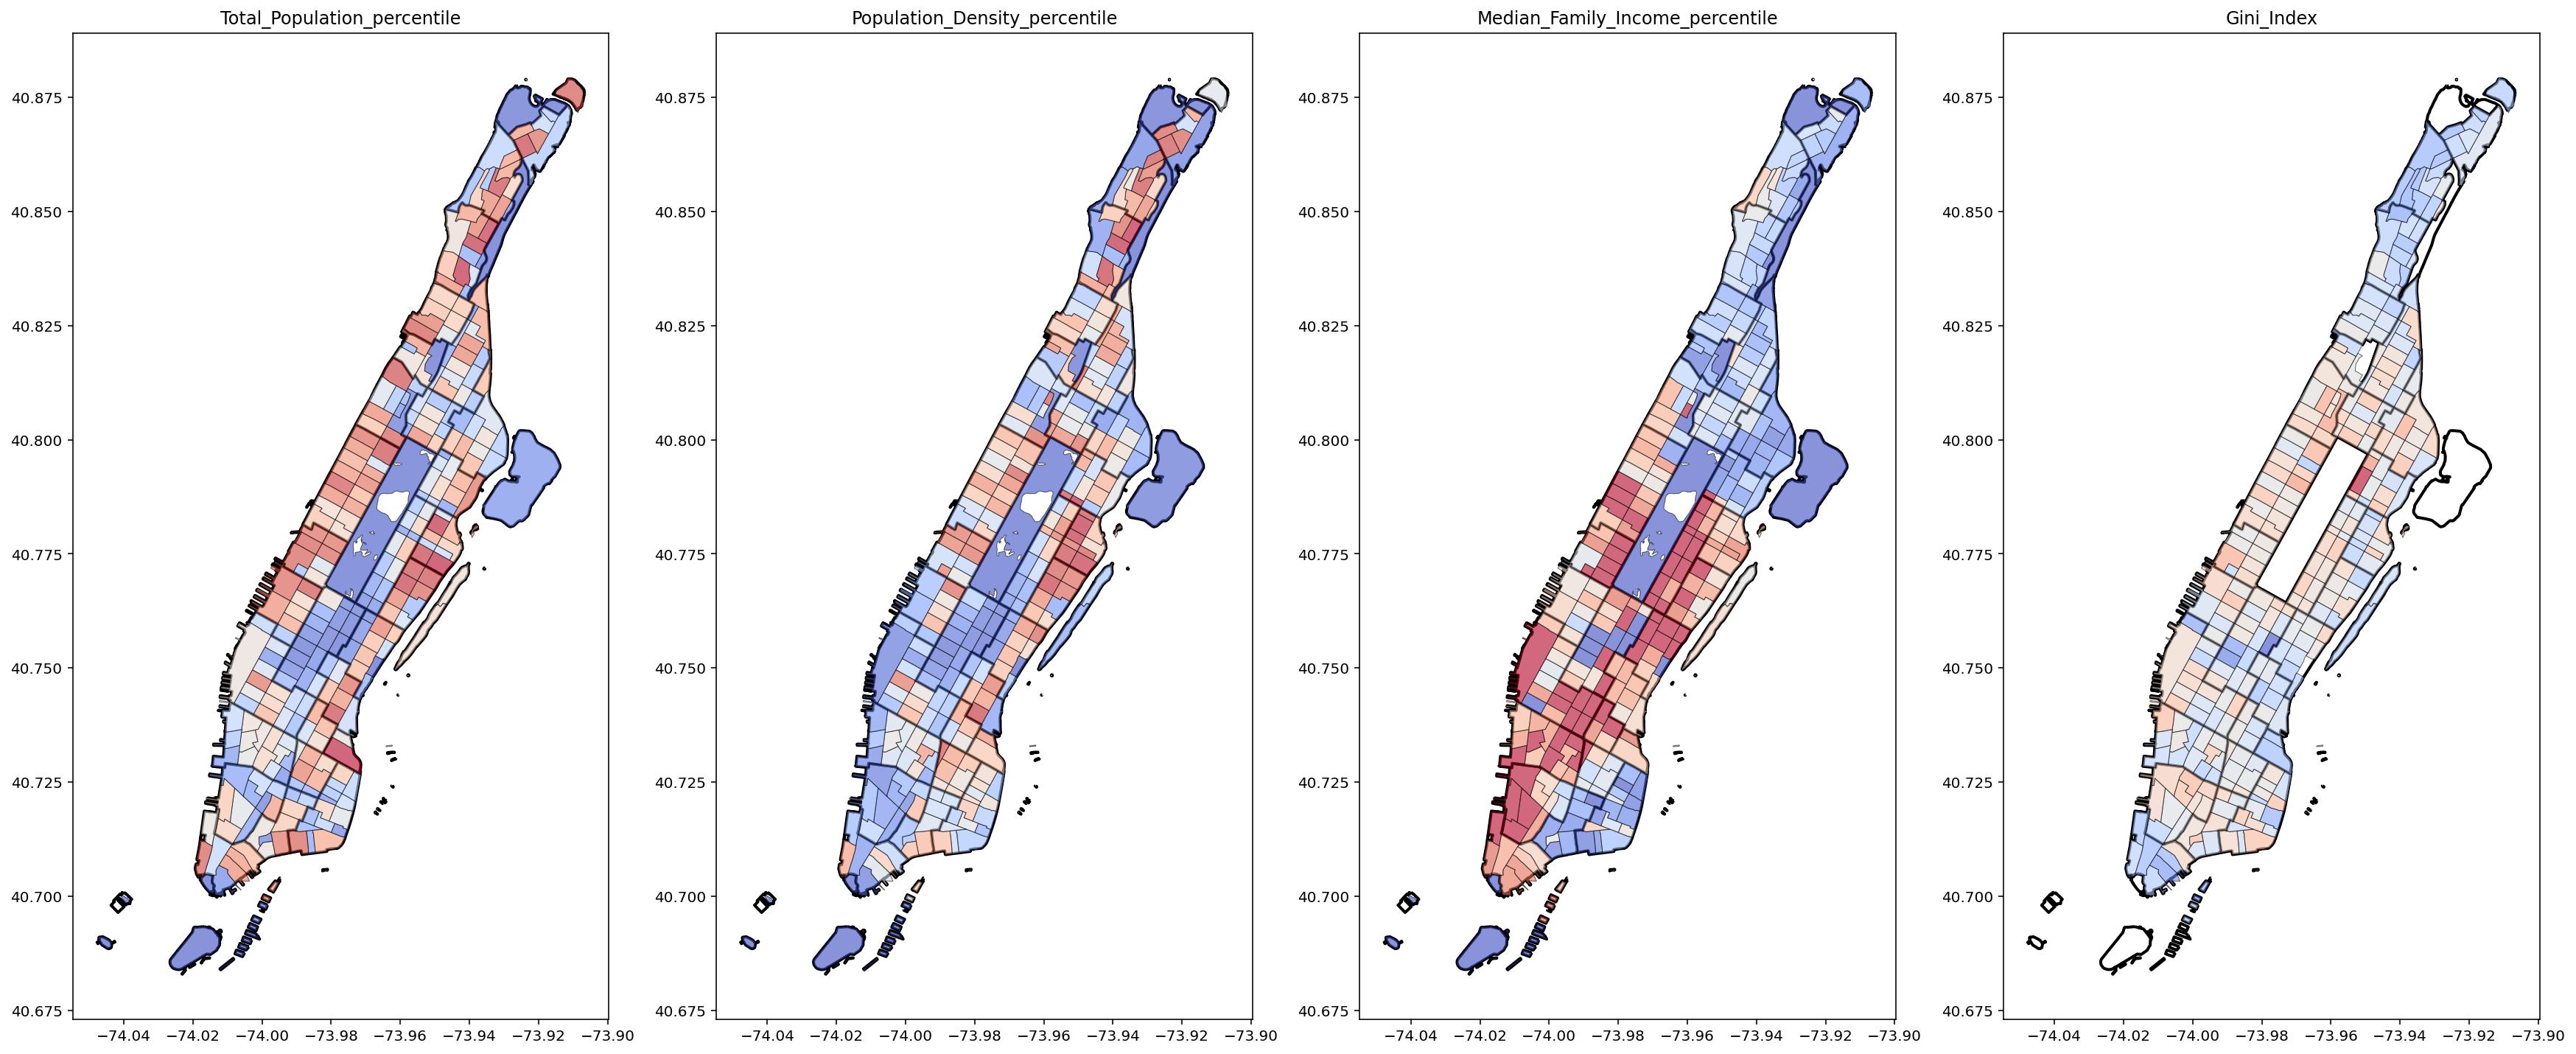

In [34]:

# Create a figure, with a 1x4 grid. 
# The "ax" is a 1-dimensional array with 4 elements
fig, ax = plt.subplots(nrows=1, ncols=4, figsize =(30,15))

# We now create one plot for each of the 4 "axes" and put the plot in the 
# corresponding ax
plot_variable(population_df, "Total_Population", percentile=True, ax = ax[0])
plot_variable(population_df, "Population_Density", percentile=True, ax = ax[1])
plot_variable(income_df, "Median_Family_Income", percentile=True, ax = ax[2])
plot_variable(gini_df, "Gini_Index", percentile=False, ax = ax[3])



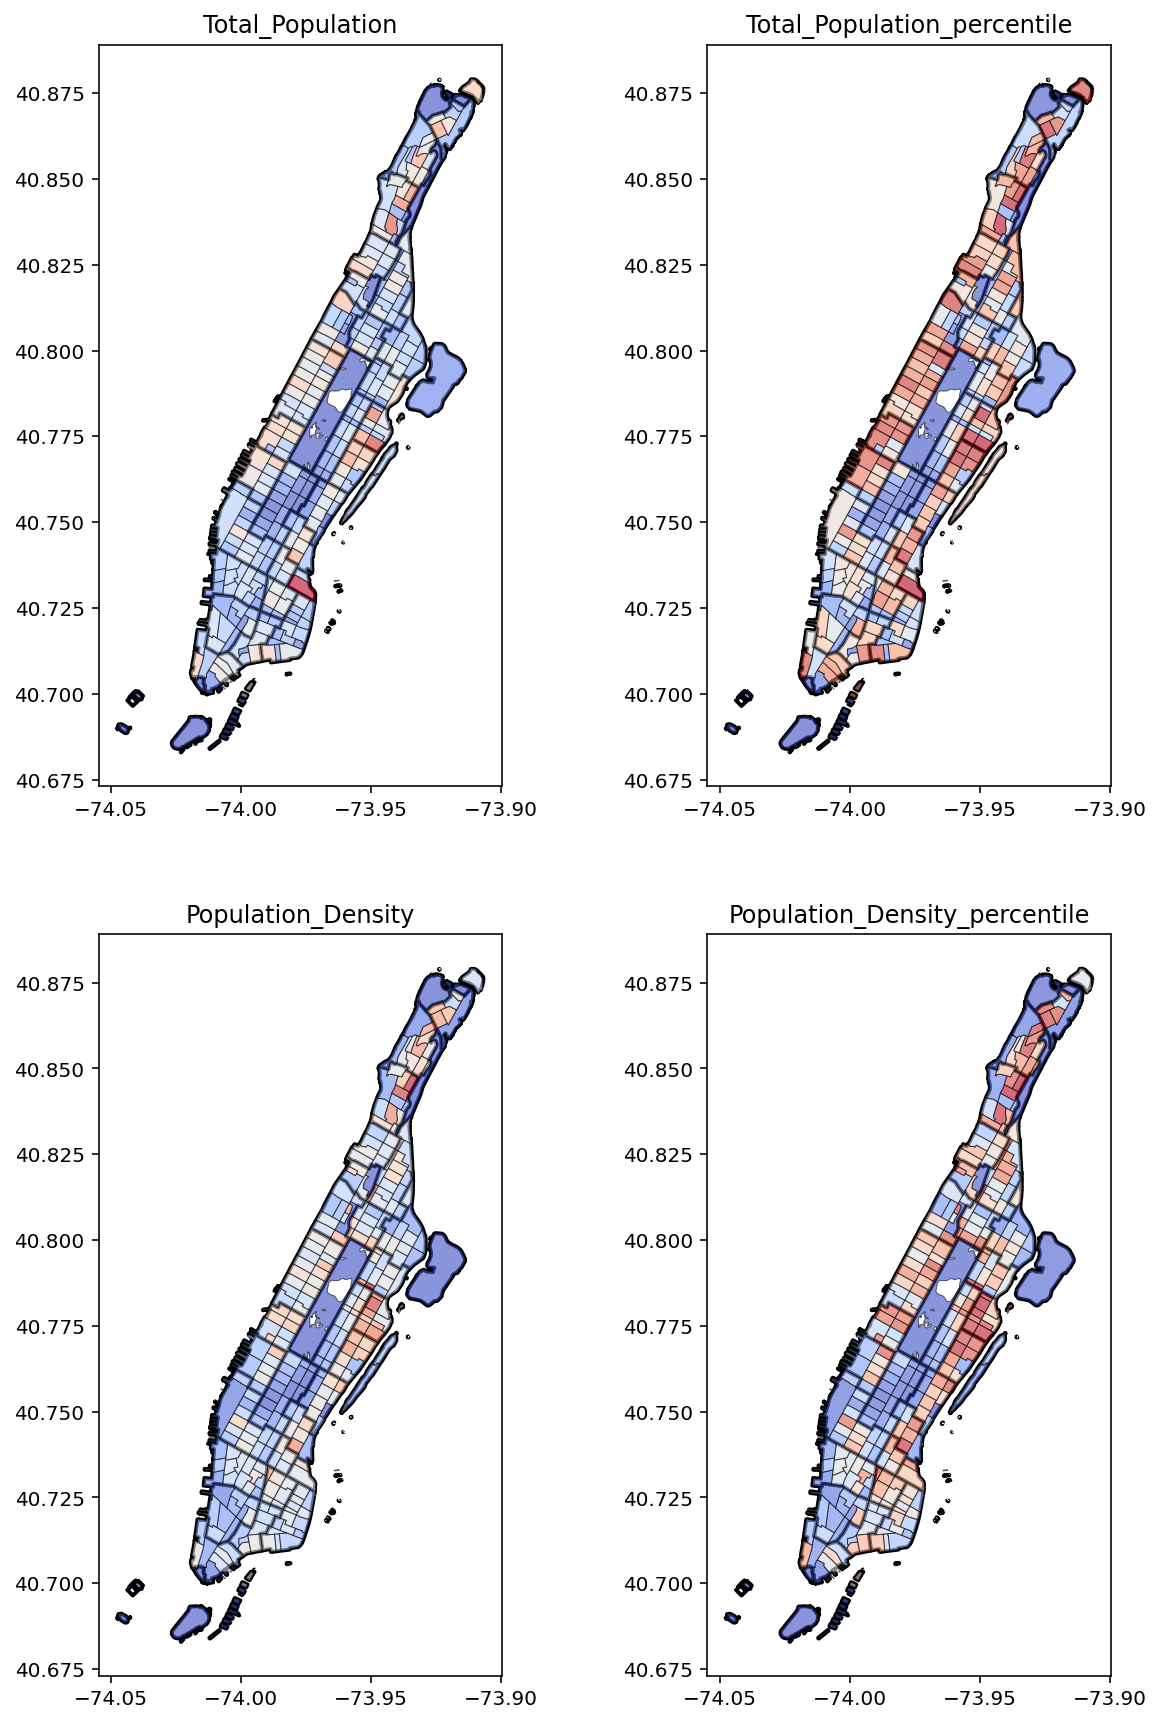

In [35]:

# Repeat, but with two rows and two columns
# Create a figure, with a 2x2 grid. The "ax" is a 2-dimensional array
fig, ax = plt.subplots(nrows=2, ncols=2, figsize =(10,15))

# We now create one plot for each of the 4 "axes" and put the plot in the 
# corresponding ax
plot_variable(population_df, "Total_Population", percentile=False, ax = ax[0][0])
plot_variable(population_df, "Total_Population", percentile=True, ax = ax[0][1])
plot_variable(population_df, "Population_Density", percentile=False, ax = ax[1][0])
plot_variable(population_df, "Population_Density", percentile=True, ax = ax[1][1])

## Plot the maps using Folium

Good tutorial at https://www.roelpeters.be/plot-choropleth-map-geopandas-folium/ and https://nbviewer.org/github/python-visualization/folium/blob/master/examples/GeoJSON_and_choropleth.ipynb#Using-choropleth-method

Consider adjusting the `StepColormap` if you want to use more bins than the default 12 ones provided by Folium.

In [36]:
# First we prepare our datasets to be easily joined
income_df['FIPS_code'] = income_df['STATEFP'] + income_df['COUNTYFP'] + income_df['TRACTCE']
geo_df['FIPS_code'] = geo_df['STATEFP'] + geo_df['COUNTYFP'] + geo_df['TRACTCE']

# Need to convert our geopandas into a format that the Choropleth function
# of Folium can understand directly. We convert to GeoJSON
geometries = geo_df[['FIPS_code', 'geometry']].set_index('FIPS_code').to_json()

# We only keep the columns that we need from the data 
income = income_df[['FIPS_code', 'Median_Family_Income', 'Median_Family_Income_percentile']]

In [37]:
import folium
fmap = folium.Map(location=[40.775, -73.95], zoom_start=12, tiles='cartodbpositron')


# We want more color bins than the default, so we create them here
quantiles = np.linspace(0,1,num=12)
bins = list(income["Median_Family_Income"].quantile(quantiles))

folium.Choropleth(geo_data=geometries, 
                data=income,
                name="Median_Family_Income",
                columns=['FIPS_code', 'Median_Family_Income'],
                key_on='feature.id',
                fill_color='RdBu_r', # Red-Blue divergent colormap, reverse order (_r) to put the red for high
                fill_opacity=0.5, 
                line_opacity=0.1,
                legend_name='Median_Family_Income',
                nan_fill_color = 'gray',
                nan_fill_opacity = 0.25,
                highlight=True,
                bins=bins 
).add_to(fmap)

folium.LayerControl().add_to(fmap)
fmap

In [22]:
bins

[22500.0,
 35792.90909090909,
 46833.18181818182,
 60201.0,
 82206.63636363637,
 124187.00000000006,
 151433.54545454544,
 195024.36363636365,
 228816.54545454547,
 250001.0,
 250001.0,
 250001.0]